In [1]:
%load_ext autoreload
%autoreload 2
import os
import pickle
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm


from src.dataloader.analysis_io import (
    load_step3_and_mm_results,
    load_step1_and_states,
    load_meas,
)
from src.main_plot_helper import recompute_s1, recompute_s2, recompute_s3


import scienceplots

plt.style.use(['ieee','notebook', 'bright'])
plt.rcParams["mathtext.fontset"] = "cm"

In [2]:
result_dir = "/system/user/tran/publicwork2/triply_efficient2/data/results/approx_recovery_jacc/"  # 6m10s at best

In [3]:
all_s1 = load_step1_and_states(
    result_dir=result_dir,
)


loaded state_type='gibbs', n=2, recs=96
loaded state_type='gibbs', n=3, recs=100
loaded state_type='gibbs', n=4, recs=100
loaded state_type='gibbs', n=5, recs=100
loaded state_type='gibbs', n=6, recs=0
loaded state_type='gibbs', n=7, recs=0
loaded state_type='special', n=2, recs=2
loaded state_type='special', n=3, recs=2
loaded state_type='special', n=4, recs=2
loaded state_type='special', n=5, recs=2
loaded state_type='special', n=6, recs=0
loaded state_type='special', n=7, recs=0
(2828, 8)


  0%|          | 0/1212 [00:00<?, ?it/s]

/system/user/publicwork/tran/triply_efficient2/src/dataloader/analysis_io.py:98: RuntimeWarning: Mean of empty slice
  lambda x: np.nanmean(x)
/system/user/tran/publicwork2/triply_efficient2/.venv/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/system/user/publicwork/tran/triply_efficient2/src/dataloader/analysis_io.py:104: RuntimeWarning: All-NaN slice encountered
  lambda x: np.nanmedian(x)


loaded and processed (1212, 14) results
Loaded (1212, 21) merged results from step1 and states


In [4]:
bigs3, all_mms3, _ = load_step3_and_mm_results(
    result_dir=result_dir,
    all_s1=all_s1,
    # n_values=[4],
    # eps_values=[0.05],
)

Loading all stage3 results from /system/user/tran/publicwork2/triply_efficient2/data/results/approx_recovery_jacc/
Found 1212 jobdirs
Found 1212 jobdirs with stage3 results


Loading stage3 result files:   0%|          | 0/1212 [00:00<?, ?it/s]

/system/user/tran/publicwork2/triply_efficient2/.venv/lib/python3.13/site-packages/pandas/core/algorithms.py:1743: RuntimeWarning: Mean of empty slice
  return lib.map_infer(values, mapper, convert=convert)
/system/user/tran/publicwork2/triply_efficient2/.venv/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/system/user/tran/publicwork2/triply_efficient2/.venv/lib/python3.13/site-packages/pandas/core/algorithms.py:1743: RuntimeWarning: All-NaN slice encountered
  return lib.map_infer(values, mapper, convert=convert)


Loaded (23873, 18) stage3 results
Found 1212 jobdirs


Loading mimicking result files:   0%|          | 0/1212 [00:00<?, ?it/s]

Discard 366 failed N1 search rows out of 24240 total.


  0%|          | 0/119365 [00:00<?, ?it/s]

In [5]:
all_s1_long = all_s1.explode(
    ["samples_needed", "preds", "Js", "trial_idx",]
)

In [6]:
selection1 = all_s1_long[
    (all_s1_long["|S|"] > 7)
    & ~(all_s1_long["samples_needed"].isna())
    & (all_s1_long["n"] == 5)
    & (all_s1_long["eps"] == 0.11)
    & (all_s1_long["Js"] >= 0.99)
]

## select all trials
gibbs = selection1[selection1["state_type"] == "gibbs"]
gibbs = next(iter(gibbs.groupby("jobdir")))[1]  # select first jobdir group of 10 trials
gibbs.sort_values("trial_idx", inplace=True)
ghz = selection1[selection1["state_type"] == "ghz"].copy()
ghz.sort_values("trial_idx", inplace=True)
zero = selection1[selection1["state_type"] == "zero"].copy()
zero.sort_values("trial_idx", inplace=True)


# step 1

## num meas. vs J metric


In [7]:
gibbs["meas"] = load_meas(gibbs, result_dir, all_trials=True)
ghz["meas"] = load_meas(ghz, result_dir, all_trials=True)
zero["meas"] = load_meas(zero, result_dir, all_trials=True)

loading /system/user/tran/publicwork2/triply_efficient2/data/results/approx_recovery_jacc/n5_eps0.11_seed340000_nt7/measurements_20250422-225607.pkl
loading /system/user/tran/publicwork2/triply_efficient2/data/results/approx_recovery_jacc/n5_eps0.11_type=ghz/measurements_20250422-225243.pkl
loading /system/user/tran/publicwork2/triply_efficient2/data/results/approx_recovery_jacc/n5_eps0.11_type=zero/measurements_20250422-225226.pkl


In [8]:
tidx = 0
allJs_gibbs = recompute_s1(gibbs.iloc[[tidx]])[0]
allJs_ghz = recompute_s1(ghz.iloc[[tidx]])[0]
allJs_zero = recompute_s1(zero.iloc[[tidx]])[0]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

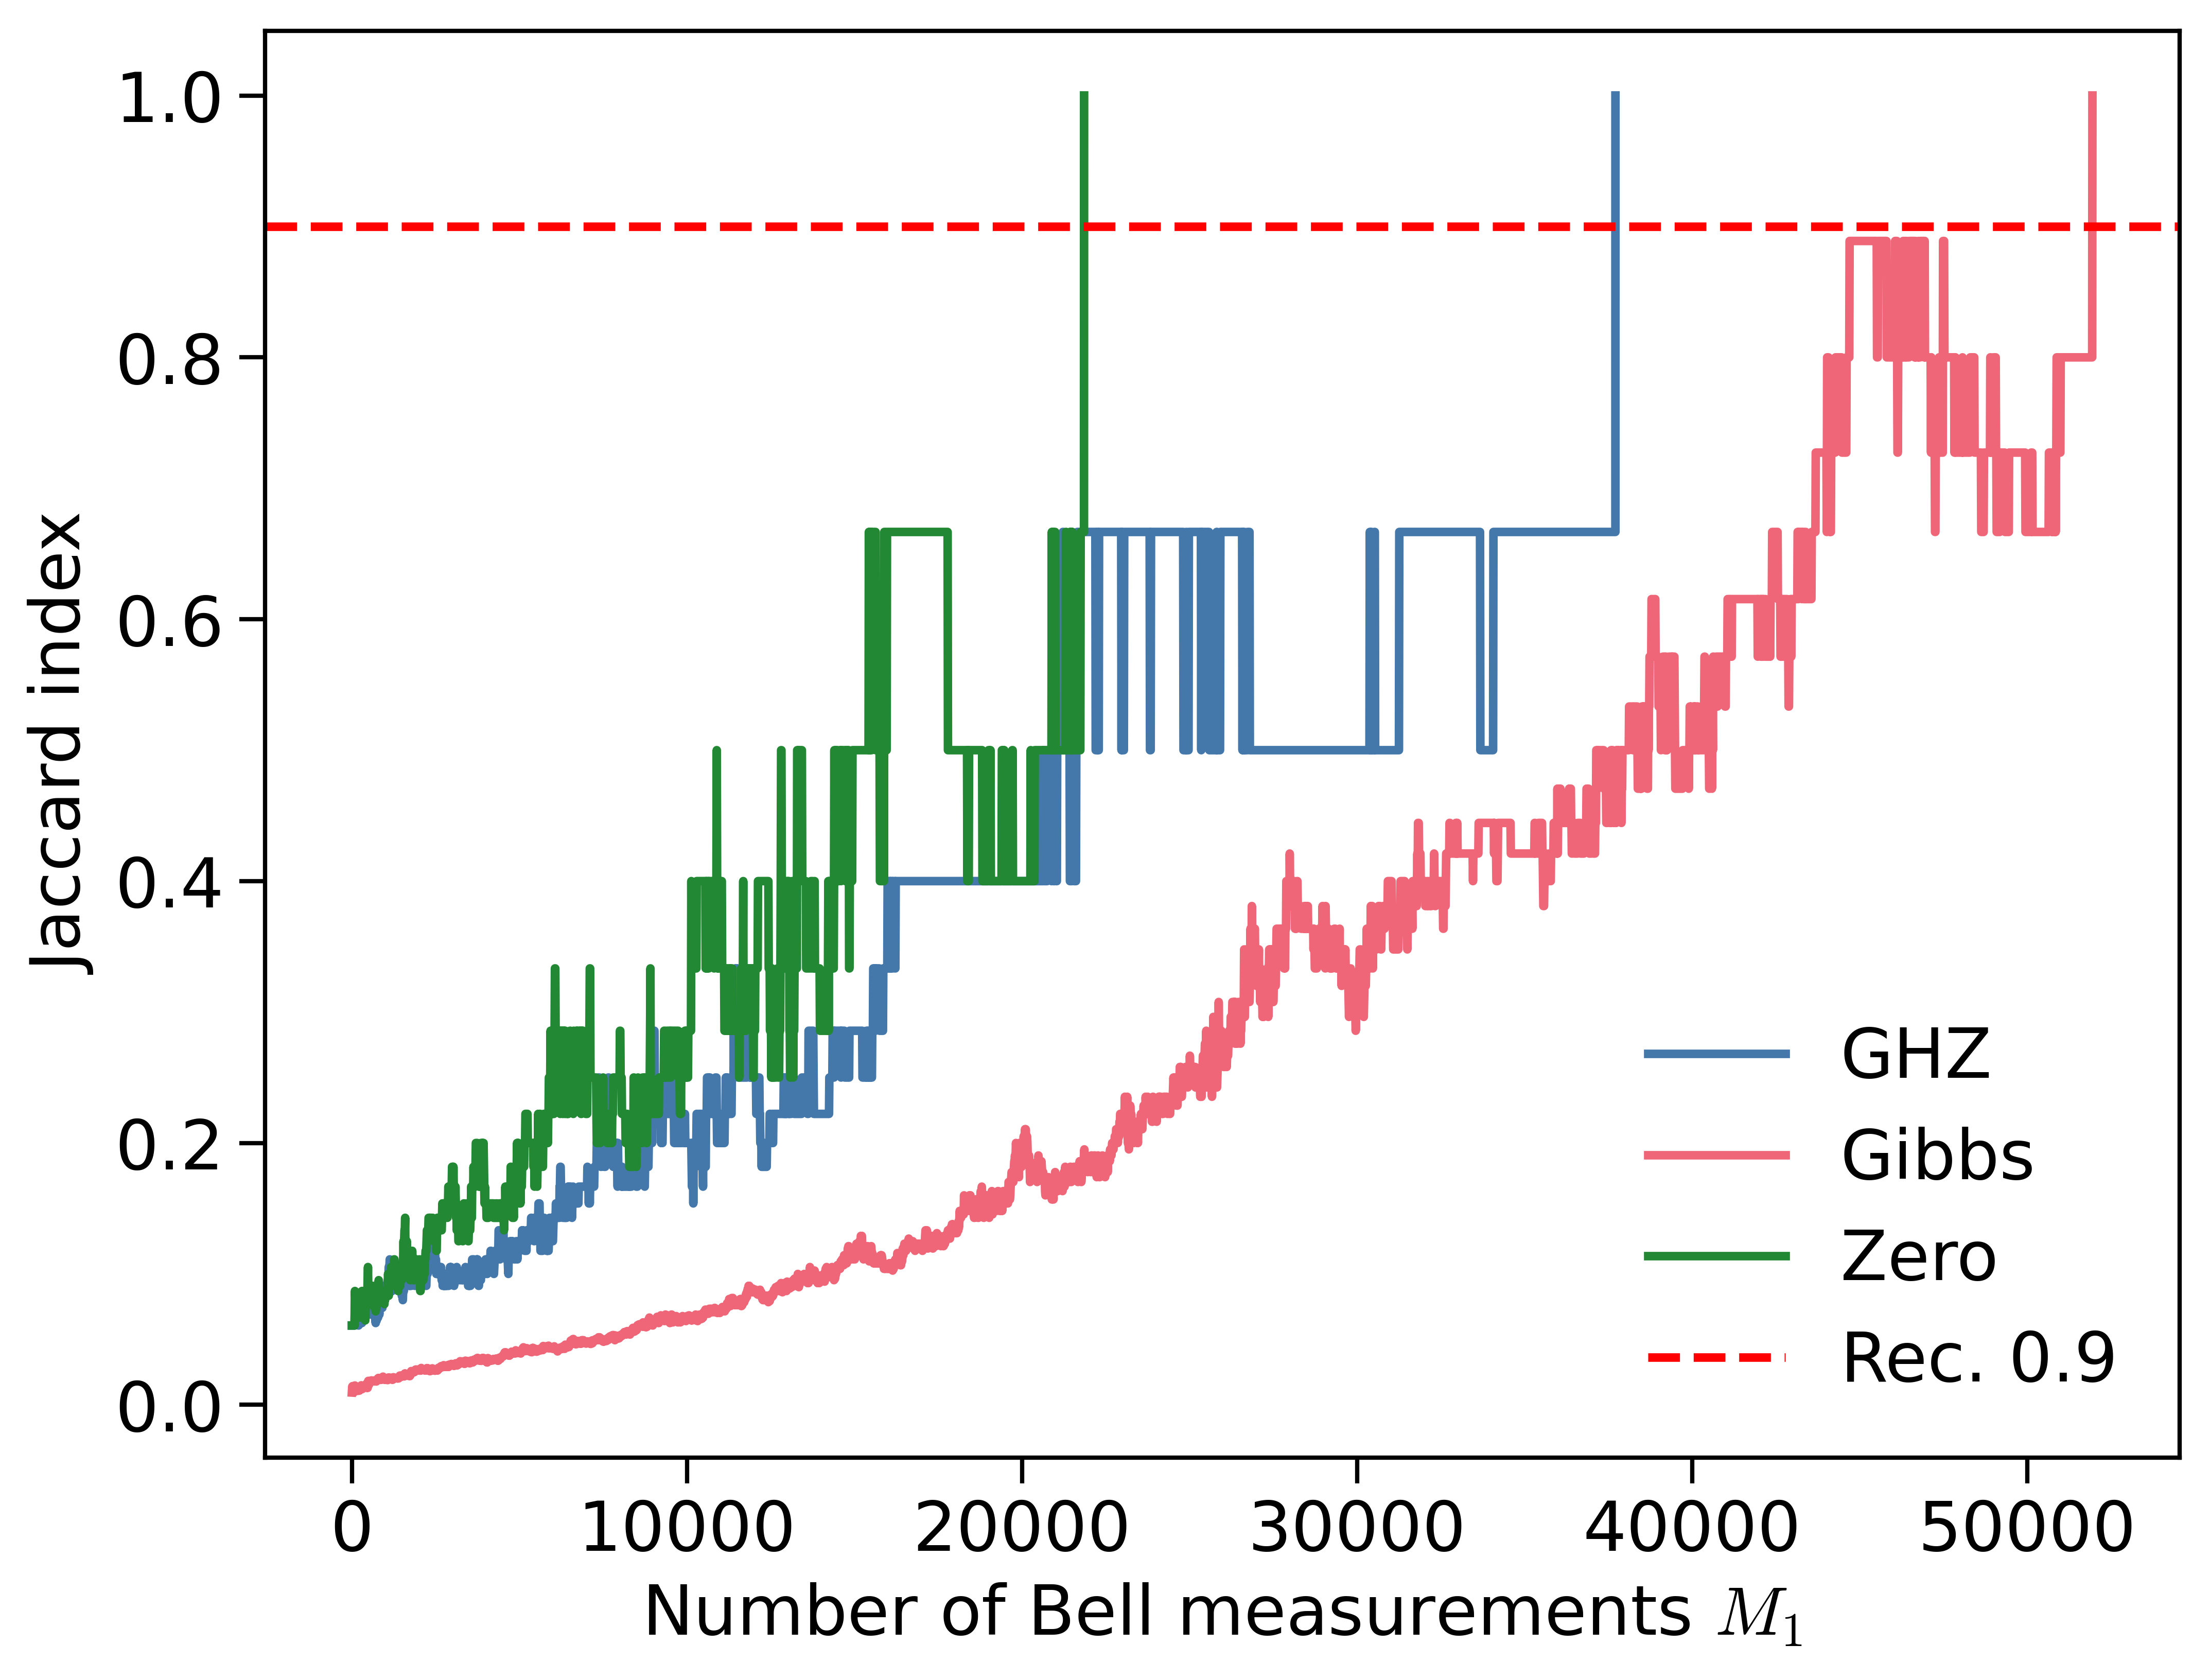

In [9]:
plt.figure()
subsample_rate = 10
markers = ["o", "s", "^"]  # different markers for each state
for state, Js, marker in zip(
    ["GHZ", "Gibbs", "Zero"], [allJs_ghz, allJs_gibbs, allJs_zero], markers
):
    sub_idcs = np.arange(0, len(Js), subsample_rate)
    if sub_idcs[-1] != len(Js) - 1:
        sub_idcs = np.append(sub_idcs, len(Js) - 1)  # take last index which converged
    plt.plot(sub_idcs, Js[sub_idcs], label=state)


plt.xlabel("Number of Bell measurements $M_1$")
plt.ylabel("Jaccard index")
plt.axhline(0.9, color="red", linestyle="--", label="Rec. 0.9")
plt.legend(loc="lower right", frameon=False)
os.makedirs("fig/main_plot", exist_ok=True)
plt.savefig("fig/main_plot/step1.pdf", bbox_inches="tight")
plt.show()

# step 2
## num updates vs ratio of violations

In [10]:
gibbs_jobdir = gibbs.iloc[0]["jobdir"]
ghz_jobdir = ghz.iloc[0]["jobdir"]
zero_jobdir = zero.iloc[0]["jobdir"]
print(gibbs_jobdir)
gibbs_mms3 = all_mms3[all_mms3["jobdir"] == gibbs_jobdir]
ghz_mms3 = all_mms3[all_mms3["jobdir"] == ghz_jobdir]
zero_mms3 = all_mms3[all_mms3["jobdir"] == zero_jobdir]
gibbs_mms3.num_updates

n5_eps0.11_seed340000_nt7


23213    59.0
23214    58.0
23215    59.0
23216    64.0
23217    62.0
23218    62.0
23219    60.0
23220    61.0
23221    58.0
23222    57.0
23223    15.0
23224    15.0
23225    18.0
23226    15.0
23227    19.0
23228    15.0
23229    19.0
23230    15.0
23231    15.0
23232    15.0
Name: num_updates, dtype: float64

In [11]:
tidx = 0
ghz_v1 = ghz_mms3.iloc[tidx]
ghz_v2 = ghz_mms3.iloc[tidx + 10]
gibbs_v1 = gibbs_mms3.iloc[tidx]
gibbs_v2 = gibbs_mms3.iloc[tidx + 10]
zero_v1 = zero_mms3.iloc[tidx]
zero_v2 = zero_mms3.iloc[tidx + 10]

all_res_v1 = []
all_res_v2 = []

for case in [ghz_v1, gibbs_v1, zero_v1]:
    res = recompute_s2(case, all_s1)
    all_res_v1.append(res)

for case in [ghz_v2, gibbs_v2, zero_v2]:
    res = recompute_s2(case, all_s1)
    all_res_v2.append(res)

num_updates recomputed=	543 vs	recorded 543.0
converged recomputed=	True vs	recorded True
num_updates recomputed=	59 vs	recorded 59.0
converged recomputed=	True vs	recorded True
num_updates recomputed=	543 vs	recorded 543.0
converged recomputed=	True vs	recorded True
num_updates recomputed=	14 vs	recordedld 14.0
converged recomputed=	True vs	recorded True
num_updates recomputed=	15 vs	recordedld 15.0
converged recomputed=	True vs	recorded True
num_updates recomputed=	14 vs	recordedld 14.0
converged recomputed=	True vs	recorded True


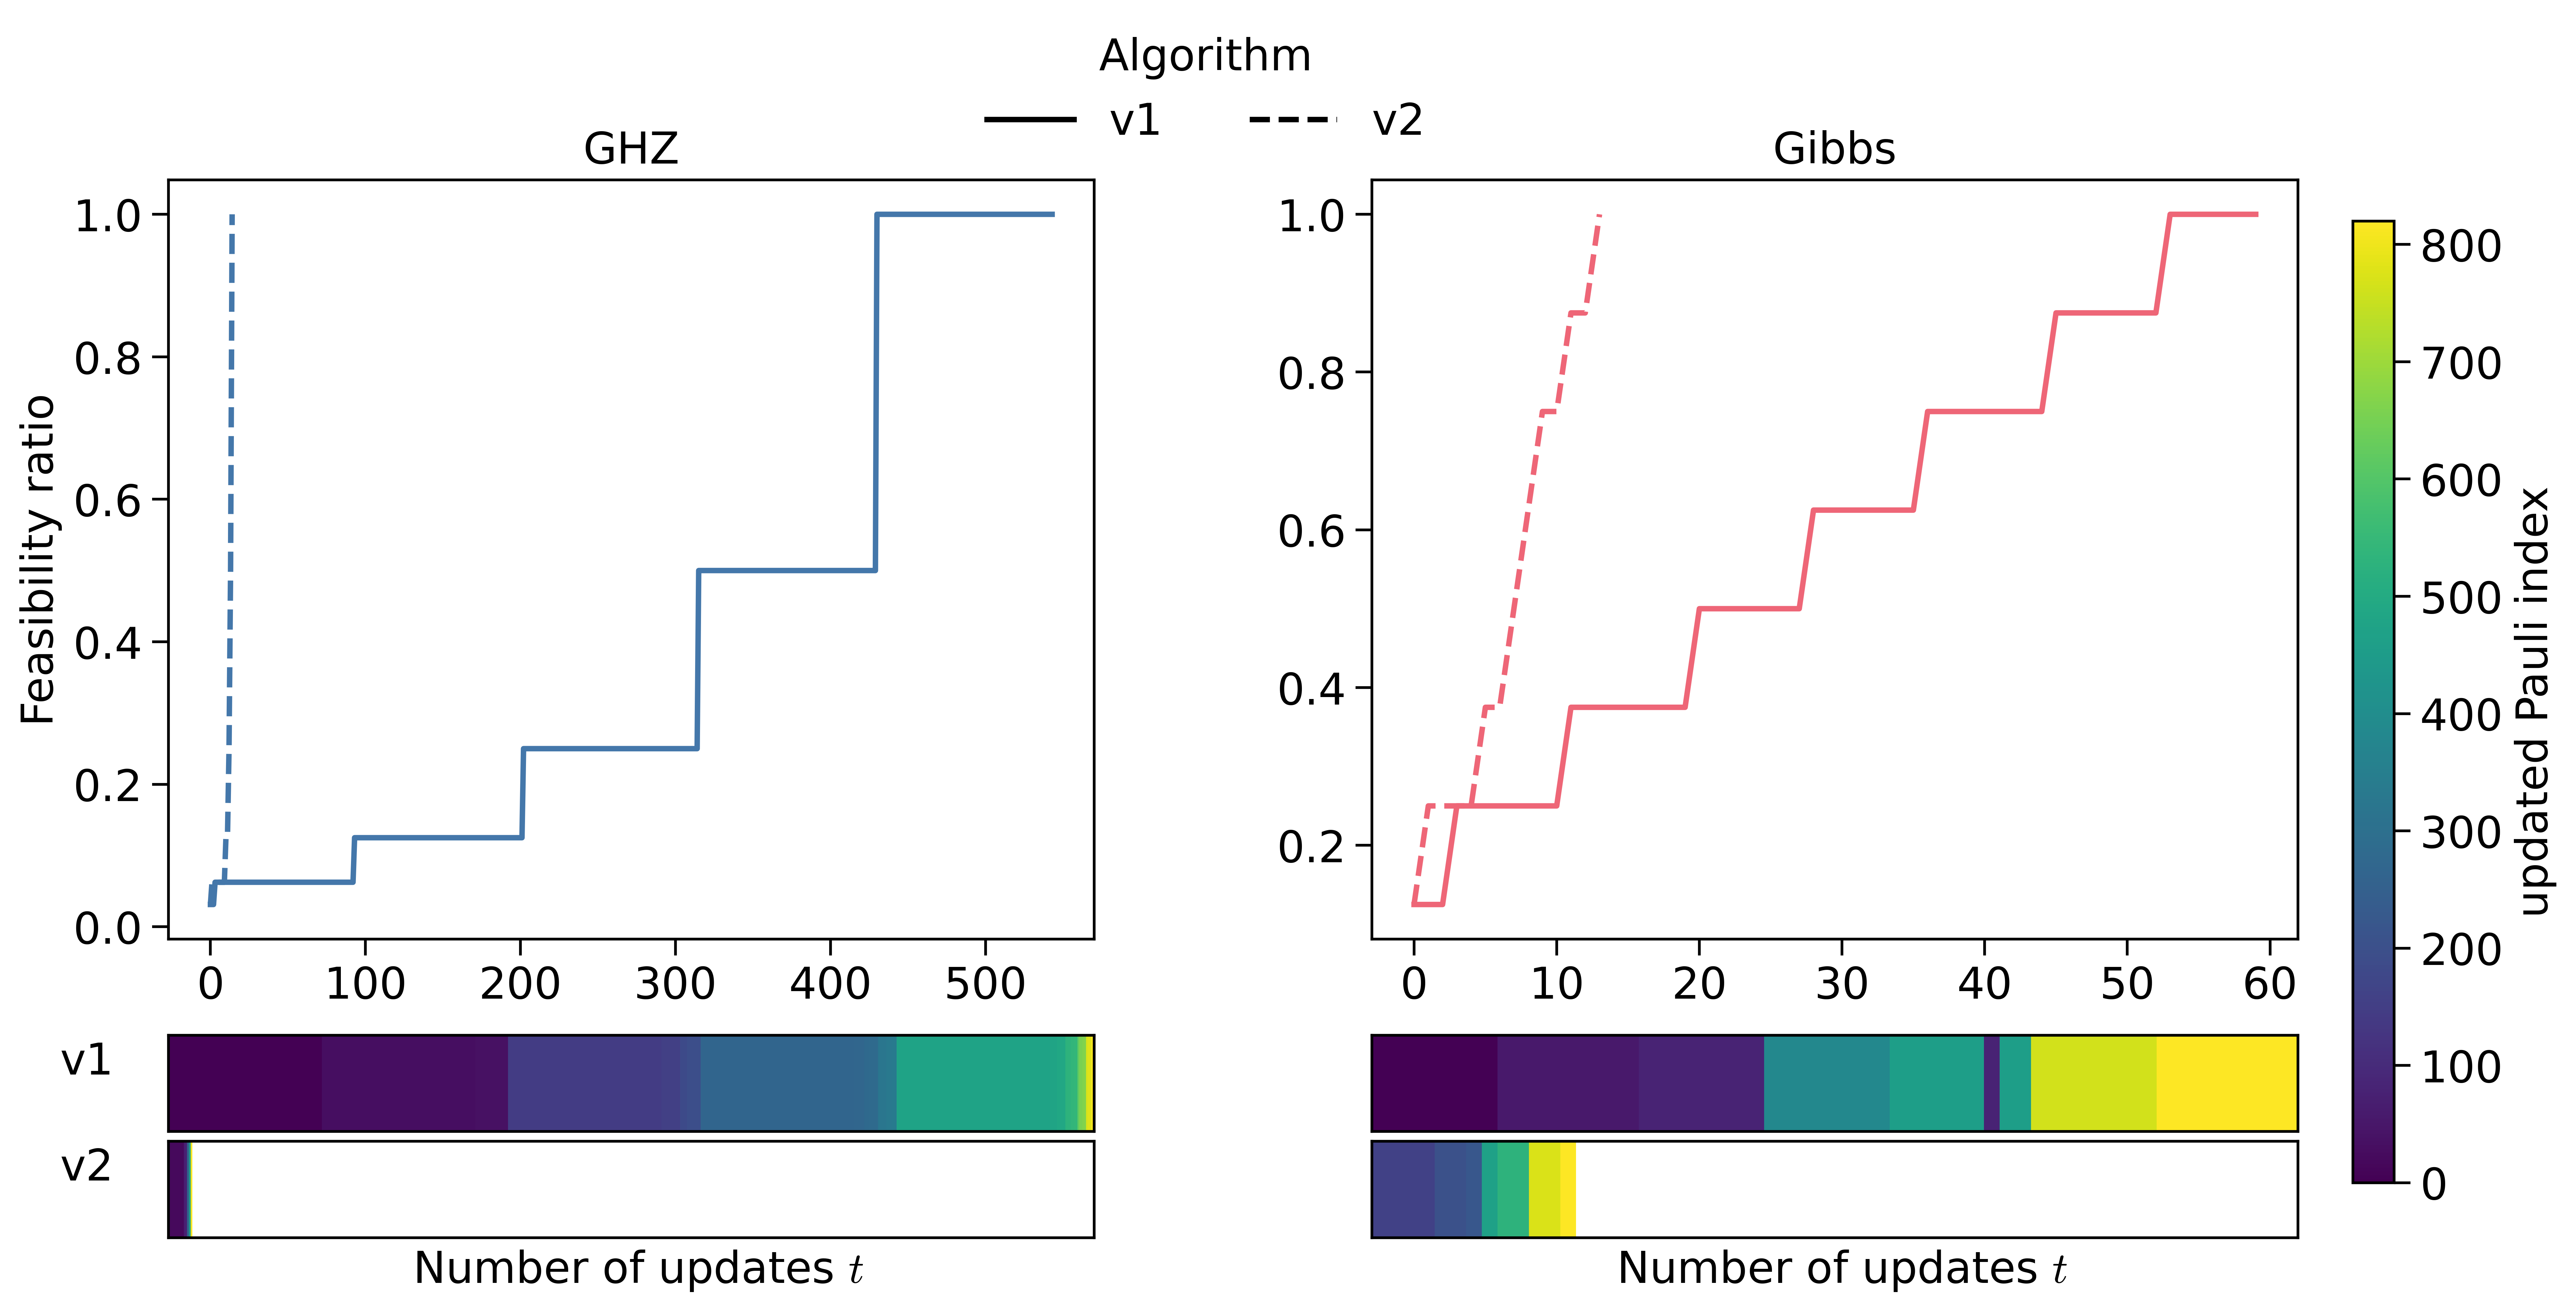

In [12]:
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D

# Updated state names and colors (removed "Zero")
states = ["GHZ", "Gibbs"]
colors = ["C0", "C1"]
cmap = "viridis"

fig = plt.figure(figsize=(14, 7))
# Main grid: top row for feasibility, bottom block for imshows.
gs_master = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[3, 0.8])

# --- Top grid: Feasibility plots (1 row, 2 cols) ---
gs_top = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs_master[0], wspace=0.3)
axes_top = [fig.add_subplot(gs_top[0, col]) for col in range(2)]

for col, (state, color, res_v1, res_v2) in enumerate(
    zip(states, colors, all_res_v1[:2], all_res_v2[:2])
):
    ax = axes_top[col]
    ax.plot(res_v1["feasibility_ratio_seq"], color=color, label="v1")
    ax.plot(res_v2["feasibility_ratio_seq"], color=color, linestyle="--", label="v2")
    ax.set_title(state)
    if col == 0:
        ax.set_ylabel("Feasibility ratio")
    if col == 1:
        custom_handles = [
            Line2D([0], [0], color="k", lw=2, linestyle="-"),
            Line2D([0], [0], color="k", lw=2, linestyle="--"),
        ]
        ax.legend(
            custom_handles,
            ["v1", "v2"],
            title="Algorithm",
            # loc="lower left",
            bbox_to_anchor=(0.1, 1.24),
            ncol=2,
            frameon=False,
        )

# --- Bottom grid: Imshow panels (2 rows, 2 cols) for v1 and v2 ---
gs_bottom = gridspec.GridSpecFromSubplotSpec(
    2, 2, subplot_spec=gs_master[1], hspace=0.1, wspace=0.3
)
axes_bottom_v1 = [fig.add_subplot(gs_bottom[0, col]) for col in range(2)]
axes_bottom_v2 = [fig.add_subplot(gs_bottom[1, col]) for col in range(2)]

# v1 imshows
for col, (state, res_v1) in enumerate(zip(states, all_res_v1[:2])):
    ax = axes_bottom_v1[col]
    seq = np.array(res_v1["selected_labels"])
    img = seq.reshape(1, -1)
    # ax.imshow(img, aspect="auto", cmap="viridis", vmin=seq.min(), vmax=seq.max())
    ax.imshow(img, aspect="auto", cmap=cmap, vmin=seq.min(), vmax=seq.max())
    ax.set_xticks([])
    ax.set_yticks([])
    if col == 0:
        ax.set_ylabel("v1", rotation=0, labelpad=30, fontsize=16)

# v2 imshows (pad to match v1 length)
for col, (state, res_v2, res_v1) in enumerate(
    zip(states, all_res_v2[:2], all_res_v1[:2])
):
    ax = axes_bottom_v2[col]
    seq_v2 = np.array(res_v2["selected_labels"])
    seq_v1 = np.array(res_v1["selected_labels"])
    desired_length = len(seq_v1)
    if len(seq_v2) < desired_length:
        pad_length = desired_length - len(seq_v2)
        seq_v2 = np.pad(seq_v2, (0, pad_length), mode="constant", constant_values=0)
    
    # Create masked array where padded entries (== 0) are masked
    mask = np.zeros_like(seq_v2, dtype=bool)
    if len(res_v2["selected_labels"]) < desired_length:
        mask[len(res_v2["selected_labels"]) :] = True
    masked_img = np.ma.masked_array(seq_v2.reshape(1, -1), mask.reshape(1, -1))

    # Use a colormap with white for masked ("bad") values
    cmap = plt.cm.viridis.copy()
    cmap.set_bad("white")

    # Show masked imshow
    ax.imshow(
        masked_img, aspect="auto", cmap=cmap, vmin=seq_v2.min(), vmax=seq_v2.max()
    )

    ax.set_xticks([])
    ax.set_yticks([])
    if col == 0:
        ax.set_ylabel("v2", rotation=0, labelpad=30, fontsize=16)
    ax.set_xlabel(" Number of updates $t$", fontsize=16)
    ax.tick_params(axis="x", which="both", labelbottom=True)

# Common colorbar for the bottom imshows
cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
fig.colorbar(
    axes_bottom_v2[-1].images[-1],
    cax=cbar_ax,
    orientation="vertical",
    label="updated Pauli index",
)

plt.savefig("fig/main_plot/step2_w_cbar.pdf", bbox_inches="tight")
plt.show()

# step 3

## num meas vs sign agreeness

In [13]:
gibbs_jobdir = gibbs.iloc[0]["jobdir"]
ghz_jobdir = ghz.iloc[0]["jobdir"]
zero_jobdir = zero.iloc[0]["jobdir"]
print(gibbs_jobdir)

n5_eps0.11_seed340000_nt7


In [14]:
gibbs_s3 = bigs3[bigs3["jobdir"] == gibbs_jobdir]
ghz_s3 = bigs3[bigs3["jobdir"] == ghz_jobdir]
zero_s3 = bigs3[bigs3["jobdir"] == zero_jobdir]

In [15]:
tidx = 0
all_sign_agree_gibbs, all_norm_hs_gibbs = recompute_s3(gibbs_s3.iloc[[tidx]])
all_sign_agree_ghz, all_norm_hs_ghz = recompute_s3(ghz_s3.iloc[[tidx]])
all_sign_agree_zero, all_norm_hs_zero = recompute_s3(zero_s3.iloc[[tidx]])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [16]:
# unpack single trials
all_sign_agree_gibbs = all_sign_agree_gibbs[0]
all_sign_agree_ghz = all_sign_agree_ghz[0]
all_sign_agree_zero = all_sign_agree_zero[0]
all_norm_hs_gibbs = all_norm_hs_gibbs[0]
all_norm_hs_ghz = all_norm_hs_ghz[0]
all_norm_hs_zero = all_norm_hs_zero[0]

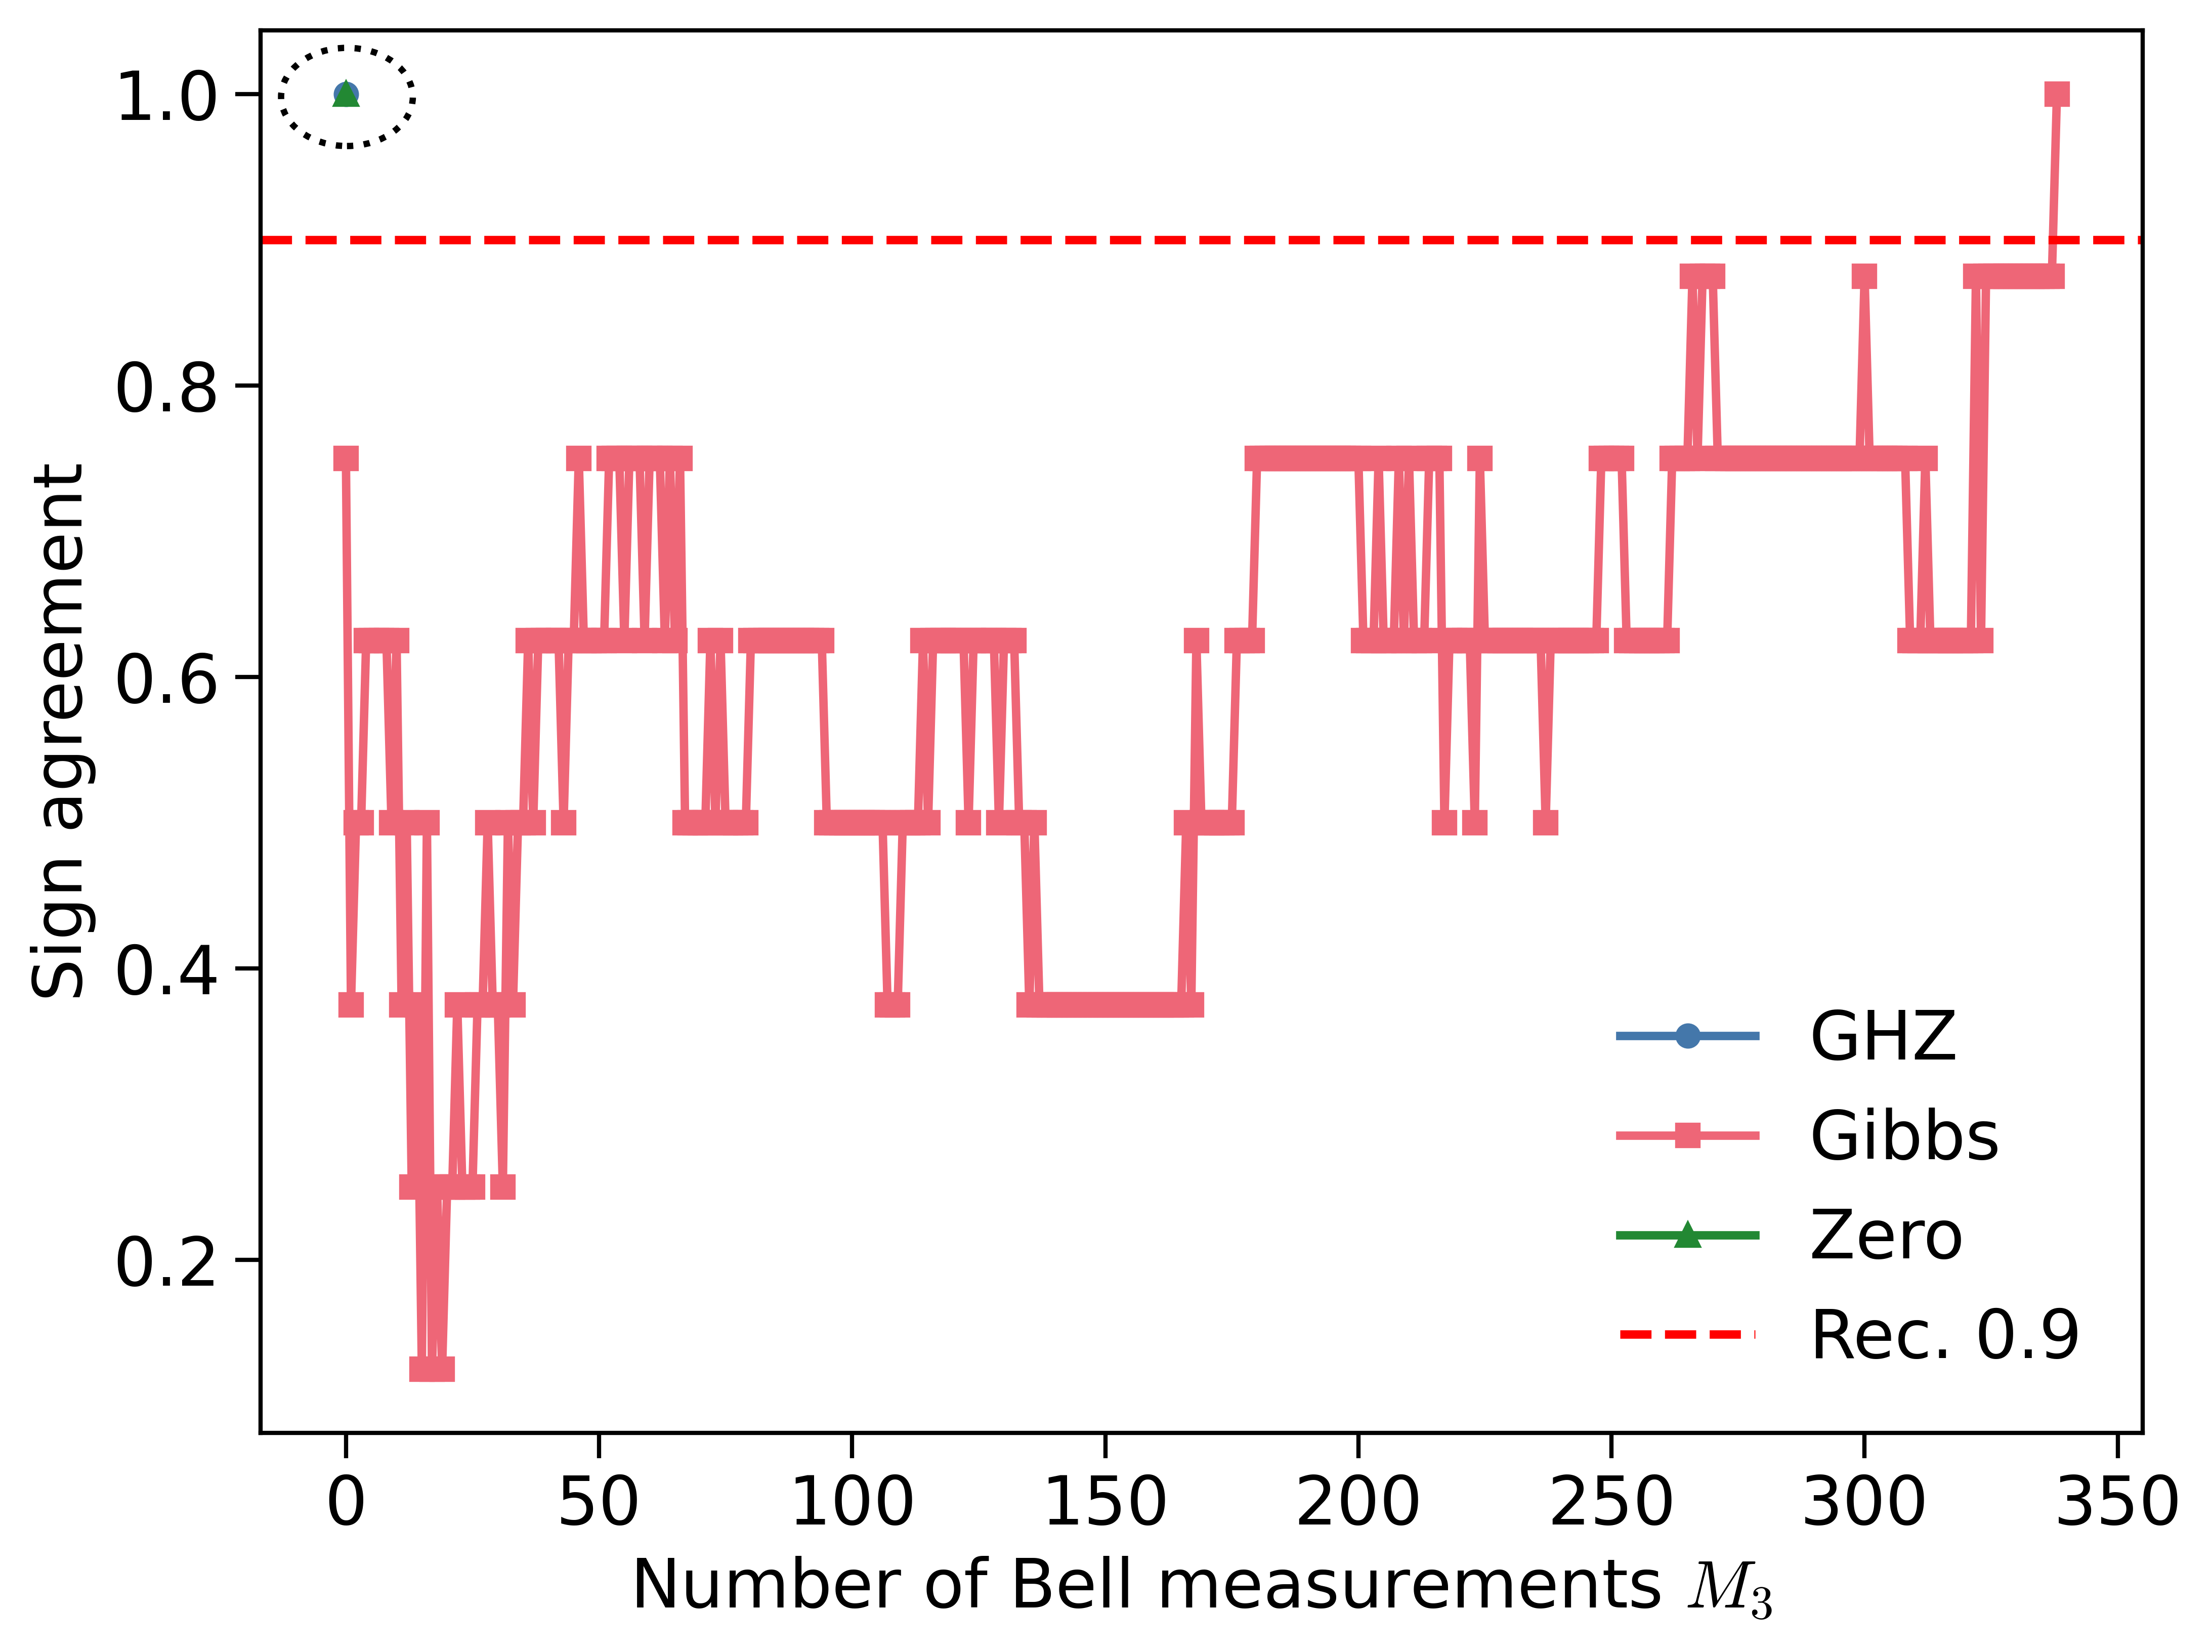

In [17]:
import matplotlib.patches as patches

plt.figure()
subsample_rate = 1

markers = ["o", "s", "^"]  # different markers for each state
for state, sign_agree_ratio, marker in zip(
    ["GHZ", "Gibbs", "Zero"],
    [
        all_sign_agree_ghz,
        all_sign_agree_gibbs,
        all_sign_agree_zero,
    ],
    markers,
):
    sub_idcs = np.arange(0, len(sign_agree_ratio), subsample_rate)
    if sub_idcs[-1] != len(sign_agree_ratio) - 1:
        sub_idcs = np.append(
            sub_idcs, len(sign_agree_ratio) - 1
        )  # take last index which converged
    plt.plot(
        sub_idcs,
        sign_agree_ratio[sub_idcs],
        label=state,
        marker=marker,
        markersize=5,
        alpha=1,
    )


ax = plt.gca()
# Define a circle in axis coordinates: (x, y) near upper left and radius
circle = patches.Circle(
    (0.046, 0.9525),
    0.035,
    transform=ax.transAxes,
    fill=False,
    linestyle=":",
    edgecolor="black",
    linewidth=1.5,
)
ax.add_patch(circle)

plt.xlabel("Number of Bell measurements $M_3$")
plt.ylabel("Sign agreement")
# plt.title(f"$n=5, \epsilon=0.07$")
# plt.title(f"Step 3: Approximate Sign Recovery, $n=5, \epsilon=0.07$")
plt.axhline(0.9, color="red", linestyle="--", label="Rec. 0.9")
plt.legend(loc="lower right", frameon=False)
os.makedirs("fig/main_plot", exist_ok=True)
plt.savefig("fig/main_plot/step3_sign_agreement.pdf", bbox_inches="tight")
plt.show()